### Dependencies
python                    3.7.6

matplotlib                3.1.3

numpy                     1.18.1

pytorch                   1.3.1

torchvision               0.4.2

In [1]:
import torch
import numpy as np

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn

import os

In [2]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.],
        std=[0.5],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.FashionMNIST(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.FashionMNIST(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        for i in range(9):
            # define subplot
            plt.subplot(330 + 1 + i)
            # plot raw pixel data
            plt.imshow(images[i].squeeze(0), cmap=plt.get_cmap('gray'))
        # show the figure
        plt.show()

    return (train_loader, valid_loader)

In [3]:
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process
    test iterator over the CIFAR-10 dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize(
        mean=[0.],
        std=[0.5],
    )

    # define transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.FashionMNIST(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return data_loader

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [5]:
def avg_lst(lst): 
    return sum(lst) / len(lst)

In [6]:
def train_model(train_loader, valid_loader, model, criterion, optimizer, num_epochs, device):
    best_measure = 0
    best_epoch =-1
    
    train_losses = list()
    train_acc = list()
    valid_losses = list()
    valid_acc = list()
    
    for epoch in range(num_epochs):
        
        model.train(True)
        losses = train_epoch(model,  train_loader,  criterion,  device , optimizer, epoch, num_epochs)
        train_losses.append(avg_lst(losses))
        temp_acc, _ = evaluate(model, train_loader, device, criterion)
        train_acc.append(temp_acc)
        
        model.train(False)
        measure, temp_losses = evaluate(model, valid_loader, device, criterion)
        valid_acc.append(measure)
        valid_losses.append(avg_lst(temp_losses))
        
        if measure > best_measure: #higher is better or lower is better?
            bestweights= model.state_dict()
            best_measure = measure
            best_epoch = epoch+1
        print('current best', best_measure, ' at epoch ', best_epoch)
        
        # Save the model checkpoint
        torch.save(model.state_dict(), 'models/model' + str(epoch) + '.ckpt')
  
    return train_losses, train_acc, valid_losses, valid_acc

In [7]:
def train_epoch(model,  train_loader,  criterion,  device , optimizer, epoch, num_epochs):
    
    model.train()
    losses = list()
    
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (i+1) % 250 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
    return losses

In [8]:
def evaluate(model, data_loader, device, criterion):

    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        losses = list()
        for ctr, data in enumerate(data_loader):
            
            images = data[0].to(device) 
            images = images.reshape(-1, 28*28).to(device)
            outputs = model(images)
            labels = data[1].to(device)
            outputs = outputs.to(device)
            
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = correct/total

    return accuracy, losses

In [9]:
def run():
    if not os.path.exists('models'):
        os.makedirs('models')
    # Check Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define Hyper-parameters 
    input_size = 784
    hidden_size1 = 300
    hidden_size2 = 100
    num_classes = 10
    num_epochs = 5
    learning_rate = 0.05
    batch_size = 100

    data_dir = 'data/'
    augment = False
    random_seed = 1

    train_loader, valid_loader = get_train_valid_loader(data_dir,
                                                        batch_size,
                                                        augment,
                                                        random_seed,
                                                        valid_size=0.166,
                                                        shuffle=True,
                                                        show_sample=True,
                                                        num_workers=4,
                                                        pin_memory=False)
    test_loader = get_test_loader(data_dir,
                                  batch_size,
                                  shuffle=True,
                                  num_workers=4,
                                  pin_memory=False)

    # Model
    model = NeuralNet(input_size, hidden_size1, hidden_size2, num_classes).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.0, weight_decay=0)

    # Train the model
    train_losses, train_acc, valid_losses, valid_acc = train_model(train_loader, valid_loader, model, criterion, optimizer, num_epochs, device)

    # Test
    test_accuracy, _ = evaluate(model, test_loader, device, criterion)
    print('test accuracy:',test_accuracy)

    test_losses = list()
    test_acc_list = list()

    for i in range(num_epochs):
        model.load_state_dict(torch.load('models/model' + str(i) + '.ckpt'))
        test_acc, test_loss = evaluate(model, test_loader, device, criterion)
        test_losses.append(avg_lst(test_loss))
        test_acc_list.append(test_acc)

    plt.figure(figsize=(20,5))
    plt.subplot(121),
    plt.plot(train_acc, label = "Training Accuracy"),
    plt.plot(valid_acc, label = "Validation Accuracy"),
    plt.plot(test_acc_list, label = "Test Accuracy"),
    plt.title('Accuracy'),
    plt.legend(frameon = False)
    plt.subplot(122),
    plt.plot(train_losses, label = "Training Loss"),
    plt.plot(valid_losses, label = "Validation Loss"),
    plt.plot(test_losses, label = "Test Loss"),
    plt.title('Loss'),
    plt.legend(frameon = False)
    plt.show()

93.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


159.1%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


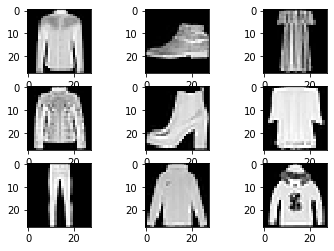

Epoch [1/5], Step [250/501], Loss: 0.8567
Epoch [1/5], Step [500/501], Loss: 0.3594
current best 0.7822289156626506  at epoch  1


In [ ]:
if __name__=='__main__':
    run()

**When you train a deep neural net, then you get after every epoch one model (actually after every minibatch). Why you should not select the best model over all epochs on the test dataset?**

To prevent from overfitting we do not select the best model over all epochs on the test dataset.